After assuming solutions of the form $F(y)e^{i(kx - \omega t)}$, the non-dimensional rotating shallow water equations have the form

\begin{align}
 -i\omega u - fv + ik\eta &= 0 \\
 -i\omega v + fu + \frac{d\eta}{dy} &= 0 \\
 -i\omega \eta + i k u + \frac{dv}{dy} &= 0
\end{align}

where the non-dimensional Coriolis frequency is $f = 1+\beta y$. (Velocities are non-dimensionalized by wavespeed,time by the inverse Coriolis frequency, and space by the deformation radius). I assume walls at the southern and northern boundaries $y=0,L$ so that the boundary conditions are $v = 0$ at $y=0,L$.

Below, I solve this equation for a single $k=2.63631578947$. I do this because I know that, for this value of $k$, certain eigenmodes $(\omega, [u,v,\eta])$ have the property that, as I increase the resolution $N$, one of the eigenfunctions $u,v,\eta$ become identically zero. This is despite the fact that theory predicts sinusoidal solutions for all three.

For the eigenmode of $k$ with the smallest postive frequency (the Kelvin mode), the radian frequency should be $\omega = k$ and the eigenfunctions should have the form:
\begin{align}
    u &= \left(\frac{\eta_0}{k^2 -1}\right)e^{-y} \\
    v &= 0 \\ 
    \eta &=\eta_0 e^{-y} \\ 
\end{align}

For an eigenmode with the $(n+1)$st positive frequency (the $n$th Poincare mode), the eigenvalue should be $\omega^2 = 1 + k^2 + l_n^2$ where $l_n = \frac{n^2\pi^2}{L^2}$, and the eigenfunctions should be

\begin{align}
 u &= -\left( \frac{1}{\omega_n^2 -1} \right) \left[\left(\omega_n + \frac{1}{\omega_n}\right)k \cos(l_ny) + \left(1 + \frac{k^2}{l_n^2} \right)l_n \sin(l_ny)  \right] \\
 v &=  \left(\frac{1}{\omega_n^2 - 1}\right)\left[\frac{k^2}{\omega_n^2 l_n^2} -1 \right] \omega_n l_n \sin(l_n y) \\
 \eta &= \eta_0\left(\cos(l_n y) - \frac{k}{l_m\omega_n} \sin(l_ny)\right)
\end{align}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dedalus import public as de
import logging
logger = logging.getLogger(__name__)
%matplotlib inline

def Eigenmodes_solver(N, k, beta, L):
    """
    Solve for the growthrates and eigenmodes.
     
    Parameters
    ----------
    N : int
        Grid resolution
    k : real
        Alongshore wavenumber
    L : real
        Width of channel
    """

    y_basis = de.Chebyshev('y', N, interval=(0, L))
    domain = de.Domain([y_basis], grid_dtype=np.complex128)

    problem = de.EVP(domain, variables=['u','v','eta'], eigenvalue='omega')

    problem.parameters['k'] = k
    problem.parameters['beta'] = beta
    problem.substitutions['f'] = "(1 + beta*y)"
    problem.substitutions['dt(A)'] = "-1j*omega*A"
    problem.substitutions['dx(A)'] = "1j*k*A"

    problem.meta[:]['y']['dirichlet'] = True
    
    problem.add_equation("dt(u) - f*v + dx(eta) = 0")
    problem.add_equation("dt(v) + f*u + dy(eta) = 0")
    problem.add_equation("dt(eta) + dx(u) + dy(v) = 0")


    problem.add_bc("left(v) = 0")
    problem.add_bc("right(v) = 0")


    solver = problem.build_solver()
    solver.solve_dense(solver.pencils[0])    

    # Filter infinite/nan eigenmodes
    finite = np.isfinite(solver.eigenvalues)
    solver.eigenvalues = solver.eigenvalues[finite]
    solver.eigenvectors = solver.eigenvectors[:,finite]
    
    # Sort eigenmodes by eigenvalue
    order = np.argsort(solver.eigenvalues)
    solver.eigenvalues = solver.eigenvalues[order]
    solver.eigenvectors = solver.eigenvectors[:,order]
    
    return domain, solver

# This function returns the inverse delta metric (see Boyd section 7.2), 
# the eigenvalue spacing sigma for the lower resolution (that is, for eigs1),
# and an array of indices that would sort eigs1 from least to greatest.
def Inverse_Delta(eigs1, eigs2):
  
    N1 = len(eigs1)
    N2 = len(eigs2)
    tol = 1e-12
    
    o1 = np.argsort(eigs1)
    o2 = np.argsort(eigs2)
    
    scale = np.zeros(N1)
    for i in range(N1):
        p = i+1
        n = i-1
        
        if i == 0:
            scale[i] = np.abs(eigs1[o1[i]] - eigs1[o1[p]])
            while (scale[i] < tol):
                if p == N1-1:
                    print("Can't determine eigenvalue pacing for {}.".format(i))
                    break
                p += 1
                scale[i] = np.abs(eigs1[o1[i]] - eigs1[o1[p]])
                
        elif i == N1-1:
            scale[i] = np.abs(eigs1[o1[i]] - eigs1[o1[n]])
            while (scale[i] < tol):
                if n == 0:
                    print("Can't determine eigenvalue pacing for {}.".format(i))
                    break
                n -= 1
                scale[i] = np.abs(eigs1[o1[i]] - eigs1[o1[n]])
        
        else:
            t1=0
            t2= 0
            
            t1 =  np.abs(eigs1[o1[n]] - eigs1[o1[i]])
            while (t1 < tol):
                if n == 0:
                    break
                n -= 1
                t1 = np.abs(eigs1[o1[n]] - eigs1[o1[i]])
           
            t2 =  np.abs(eigs1[o1[p]] - eigs1[o1[i]])
            while (t2 < tol):
                if p == N1-1:
                    break
                p += 1
                t2 = np.abs(eigs1[o1[p]] - eigs1[o1[i]])
            
            if (t1==0 and t2 == 0):
                print("Can't determine eigenvalue pacing for {}.".format(i))
            
            scale[i] = 0.5*(t1+t2)
    
    Idelta = np.zeros(N1)
    for i in range(N1):
        diff = np.zeros(N2)
        for j in range(N2):
            diff[j] = np.abs(eigs1[o1[i]] - eigs2[o2[j]])
        
        dm = diff.min(0)
        if (dm==0):
            #print("Repeat eigenvalue between two N values: {}/{}".format(i,N1))
            dm = 1e-12
            
        Idelta[i] = scale[i]/dm
        

                
    return Idelta, scale, o1

# Uses the inverse delta metric (see Boyd section 7.2) to determine which eigenvalues
# are relatively invariant after running with higher resolution.
# A tol=1e6 means that eigenmodes will be considered good if they change less than
# one part in a million after running at a higher resolution.
def GoodEigenmodes(eigs1,eigs2, tol):
    Idelta, scale, ord1 = Inverse_Delta(eigs1,eigs2)
    
    I = 0
    good = np.full(len(Idelta), False)
    for i in range(len(Idelta)):
        if Idelta[i] > tol:
            if (np.abs(eigs1[ord1[i]]) > 1e-9): ## ignoring zero eigenvalues
                good[i] = True
                I += 1
    
    indx = np.zeros(I, dtype=np.int16)
    
    I = 0
    for i in range(len(Idelta)):
        if good[i] == True:
            indx[I] = ord1[i]
            I+=1
    
    return indx

In [2]:
## This should take a few minutes to run.

k = 2.63631578947
beta = 0.0
L = 1
tol = 1e6

#NN = [32,64,(64*3)//2,128,(64*5)//2 ,(128*3)//2,(128*5)//2, (128*6)//2 ]
NN = [32,64,(64*3)//2,128,(64*5)//2]

Kmax_u = np.zeros(len(NN))
Kmax_v = np.zeros(len(NN))
Kmax_eta = np.zeros(len(NN))
Keig_freq = np.zeros(len(NN))

Pmax_u = np.zeros(len(NN))
Pmax_v = np.zeros(len(NN))
Pmax_eta = np.zeros(len(NN))
Peig_freq = np.zeros(len(NN))

KU = [None]*len(NN)
KV = [None]*len(NN)
KEta = [None]*len(NN)
KEigs = [None]*len(NN)

PU = [None]*len(NN)
PV = [None]*len(NN)
PEta = [None]*len(NN)
PEigs = [None]*len(NN)

for i in range(len(NN)):
    N = NN[i]
    N2 = (N*3)//2
    beta = 0.
    domain, solver =  Eigenmodes_solver(N,k,beta,L)
    domain2, solver2 =  Eigenmodes_solver(N2,k,beta,L)

    indx =  GoodEigenmodes(solver.eigenvalues,solver2.eigenvalues, tol)

    solver.eigenvalues = solver.eigenvalues[indx]
    solver.eigenvectors = solver.eigenvectors[:,indx]
    
    pos_eigs = np.where(solver.eigenvalues[:]>0)[0]
    
    Ku = np.zeros(N)
    Kv = np.zeros(N)
    Keta = np.zeros(N)
        
    solver.set_state(pos_eigs[0])
    KEigs[i] = solver.eigenvalues[pos_eigs[0]].real
    Ku[:] = np.abs(solver.state['u']['g'])
    KU[i] = Ku
    Kv[:] = np.abs(solver.state['v']['g'])
    KV[i] = Kv
    Keta[:] = np.abs(solver.state['eta']['g'])
    KEta[i] = Keta
    
    Kmax_u[i] = np.abs(KU[i]).max()
    Kmax_v[i] = np.abs(KV[i]).max()
    Kmax_eta[i] = np.abs(KEta[i]).max()
    
    
    Pu = np.zeros(N)
    Pv = np.zeros(N)
    Peta = np.zeros(N)
    
    solver.set_state(pos_eigs[1])
    PEigs[i] = solver.eigenvalues[pos_eigs[1]].real
    Pu[:] = np.abs(solver.state['u']['g'])
    PU[i] = Pu
    Pv[:] = np.abs(solver.state['v']['g'])
    PV[i] = Pv
    Peta[:] = np.abs(solver.state['eta']['g'])
    PEta[i] = Peta
    
    Pmax_u[i] = np.abs(PU[i]).max()
    Pmax_v[i] = np.abs(PV[i]).max()
    Pmax_eta[i] = np.abs(PEta[i]).max()

2019-01-11 16:20:50,289 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-11 16:20:50,338 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-11 16:20:50,470 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-11 16:20:50,631 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-11 16:20:51,203 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-11 16:20:51,621 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-11 16:20:53,224 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-11 16:20:54,369 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-11 16:20:58,249 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2019-01-11 16:21:00,092 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


Text(0.5,0,'N')

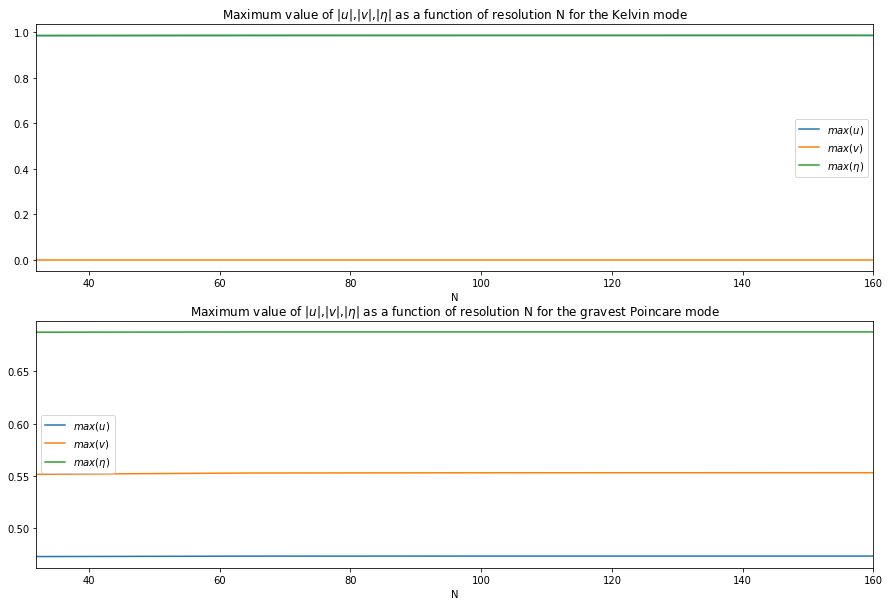

In [3]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(211)
ax1.plot(NN,Kmax_u, label=r'$max(u)$')
ax1.plot(NN,Kmax_v, label=r'$max(v)$')
ax1.plot(NN,Kmax_eta, label=r'$max(\eta)$')
ax1.legend()
ax1.set_xlim([NN[0],NN[-1]])

ax1.set_title(r'Maximum value of $|u|$,$|v|$,$|\eta|$ as a function of resolution N for the Kelvin mode')
ax1.set_xlabel('N')
#ax1.set_yscale('log')

ax2 = plt.subplot(212)
ax2.plot(NN,Pmax_u, label=r'$max(u)$')
ax2.plot(NN,Pmax_v, label=r'$max(v)$')
ax2.plot(NN,Pmax_eta, label=r'$max(\eta)$')
ax2.legend()
ax2.set_xlim([NN[0],NN[-1]])

ax2.set_title(r'Maximum value of $|u|$,$|v|$,$|\eta|$ as a function of resolution N for the gravest Poincare mode')
ax2.set_xlabel('N')
#ax2.set_yscale('log')



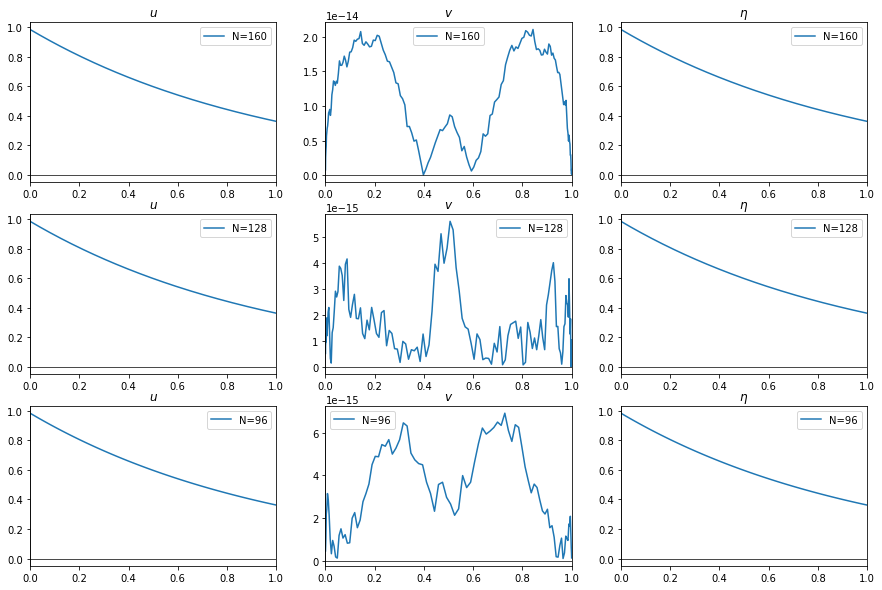

In [4]:
fig = plt.figure(figsize=(15,10))
ax11 = plt.subplot(331)
ax11.set_title(r'$u$')
ax12 = plt.subplot(332)
ax12.set_title(r'$v$')
ax13 = plt.subplot(333)
ax13.set_title(r'$\eta$')

ax21 = plt.subplot(334)
ax21.set_title(r'$u$')
ax22 = plt.subplot(335)
ax22.set_title(r'$v$')
ax23 = plt.subplot(336)
ax23.set_title(r'$\eta$')

ax31 = plt.subplot(337)
ax31.set_title(r'$u$')
ax32 = plt.subplot(338)
ax32.set_title(r'$v$')
ax33 = plt.subplot(339)
ax33.set_title(r'$\eta$')

n1 = -1
n2 = -2
n3 = -3

y_basis1 = de.Chebyshev('y', NN[n1], interval=(0, L))
domain1 = de.Domain([y_basis1], grid_dtype=np.complex128)
Y1 = domain1.grid(0, scales=domain.dealias)

y_basis2 = de.Chebyshev('y', NN[n2], interval=(0, L))
domain2 = de.Domain([y_basis2], grid_dtype=np.complex128)
Y2 = domain2.grid(0, scales=domain.dealias)

y_basis3 = de.Chebyshev('y', NN[n3], interval=(0, L))
domain3 = de.Domain([y_basis3], grid_dtype=np.complex128)
Y3 = domain3.grid(0, scales=domain.dealias)

ax11.plot(Y1,KU[n1],color='C0',label='N={}'.format(NN[n1]))
ax21.plot(Y2,KU[n2],color='C0',label='N={}'.format(NN[n2]))
ax31.plot(Y3,KU[n3],color='C0',label='N={}'.format(NN[n3]))

ax12.plot(Y1,KV[n1],color='C0',label='N={}'.format(NN[n1]))
ax22.plot(Y2,KV[n2],color='C0',label='N={}'.format(NN[n2]))
ax32.plot(Y3,KV[n3],color='C0',label='N={}'.format(NN[n3]))

ax13.plot(Y1,KEta[n1],color='C0',label='N={}'.format(NN[n1]))
ax23.plot(Y2,KEta[n2],color='C0',label='N={}'.format(NN[n2]))
ax33.plot(Y3,KEta[n3],color='C0',label='N={}'.format(NN[n3]))

AX = [ax11,ax12,ax13,ax21,ax22,ax23,ax31,ax32,ax33]
for ax in AX:
    ax.set_xlim([Y1[0],Y1[-1]])
    ax.axhline(y=0,linewidth=0.7, color='k')
    ax.axvline(x=0,linewidth=0.7, color='k')
    ax.legend()

In [5]:
print("Computed eigenvalue = {}".format(KEigs[-1]))
print("Theoretical eigenvalue = {}".format(k))

Computed eigenvalue = 2.636315789469989
Theoretical eigenvalue = 2.63631578947


Above, I plot the eigenfunctions of the Kelvin mode for three resolutions. This mode shows the proper behavior with $v=0$ and $u,\eta$ having exponential behavior. The maximum value of $u,\eta$ changes with resolution, but the relative magnitude of the three eigenfucntions $u,v,\eta$ are approximately the same for the three resolutions. 

(But why does the maximum value of $u$, $\eta$ change with $N$?)

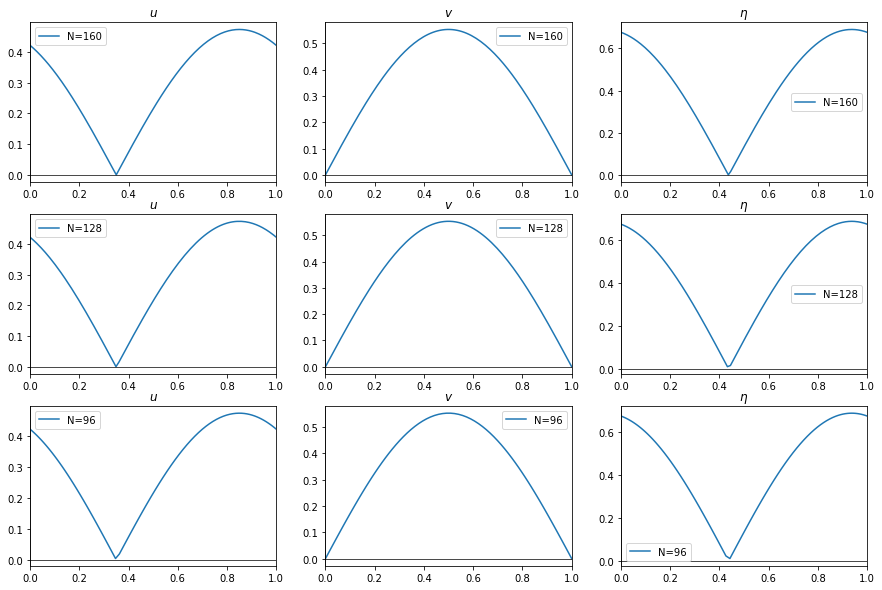

In [6]:
fig = plt.figure(figsize=(15,10))
ax11 = plt.subplot(331)
ax11.set_title(r'$u$')
ax12 = plt.subplot(332)
ax12.set_title(r'$v$')
ax13 = plt.subplot(333)
ax13.set_title(r'$\eta$')

ax21 = plt.subplot(334)
ax21.set_title(r'$u$')
ax22 = plt.subplot(335)
ax22.set_title(r'$v$')
ax23 = plt.subplot(336)
ax23.set_title(r'$\eta$')

ax31 = plt.subplot(337)
ax31.set_title(r'$u$')
ax32 = plt.subplot(338)
ax32.set_title(r'$v$')
ax33 = plt.subplot(339)
ax33.set_title(r'$\eta$')

n1 = -1
n2 = -2
n3 = -3

y_basis1 = de.Chebyshev('y', NN[n1], interval=(0, L))
domain1 = de.Domain([y_basis1], grid_dtype=np.complex128)
Y1 = domain1.grid(0, scales=domain.dealias)

y_basis2 = de.Chebyshev('y', NN[n2], interval=(0, L))
domain2 = de.Domain([y_basis2], grid_dtype=np.complex128)
Y2 = domain2.grid(0, scales=domain.dealias)

y_basis3 = de.Chebyshev('y', NN[n3], interval=(0, L))
domain3 = de.Domain([y_basis3], grid_dtype=np.complex128)
Y3 = domain3.grid(0, scales=domain.dealias)

ax11.plot(Y1,PU[n1],color='C0',label='N={}'.format(NN[n1]))
ax21.plot(Y2,PU[n2],color='C0',label='N={}'.format(NN[n2]))
ax31.plot(Y3,PU[n3],color='C0',label='N={}'.format(NN[n3]))

ax12.plot(Y1,PV[n1],color='C0',label='N={}'.format(NN[n1]))
ax22.plot(Y2,PV[n2],color='C0',label='N={}'.format(NN[n2]))
ax32.plot(Y3,PV[n3],color='C0',label='N={}'.format(NN[n3]))

ax13.plot(Y1,PEta[n1],color='C0',label='N={}'.format(NN[n1]))
ax23.plot(Y2,PEta[n2],color='C0',label='N={}'.format(NN[n2]))
ax33.plot(Y3,PEta[n3],color='C0',label='N={}'.format(NN[n3]))

AX = [ax11,ax12,ax13,ax21,ax22,ax23,ax31,ax32,ax33]
for ax in AX:
    ax.set_xlim([Y1[0],Y1[-1]])
    ax.axhline(y=0,linewidth=0.7, color='k')
    ax.axvline(x=0,linewidth=0.7, color='k')
    ax.legend()

In [7]:
print("Computed eigenvalue = {}".format(PEigs[-1]))
print("Theoretical eigenvalue = {}".format(np.sqrt(1+k**2+np.pi**2/L**2)))

Computed eigenvalue = 4.221346389826195
Theoretical eigenvalue = 4.22134638982614


Here is where I get strange behavior. As I increase the resolution, the relative magnitudes of $u,v,\eta$ change (although they should not!). Note that between $N=320$ and $N=192$ the values of $v$ remain the same, but the fields $u,\eta$ take different values. Thus the ratios $u/v$ and $\eta/v$ are a function of resolution.

**More significantly, once the resolution reaches $N=384$, the field $v$ becomes identically zero when in fact it should look like a $\sin(l_n y)$**.